In [1]:
import csv
from tabulate import tabulate
import pandas as pd
from pyspark import SparkContext
import numpy as np
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import pyspark as ps

We changed the csv data file to a tabular data file

In [ ]:
# Open the CSV file and read its contents
with open('winemag-data-130k-v2.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    data = [row for row in reader]

# Convert the data to a tabular format
table = tabulate(data, headers='firstrow', tablefmt='tsv')

# Write the tabular data to a file
with open('output.txt', 'w') as txtfile:
    txtfile.write(table)

Define needed functions for prepprocessing lines and mapping functions

In [2]:
# Define a method for reading and processing individual lines of a text file
def preprocessLine(line):
    import re
    
    # Remove all non-alphabet characters with a regular expression
    text_alpha = re.sub(r'[^a-zA-Z]', ' ', line)

    # Convert characters to upper-case
    text_upper = text_alpha.upper()
    
    # Convert the string of text into a list of words and remove empty words
    words = [w for w in text_upper.split(' ') if w != '']
    
    return words

# Given a key and value, return a (key, value) pair
def makeKeyValue(key, value=1):
    return (key, value)

# Count (reduce) the values for a given key (word length)
def addValues(val1, val2):
    return val1 + val2

Read in the data and map it by key value

In [3]:
# Create the RDD containing the text
sc = SparkContext.getOrCreate()
data = sc.textFile("output.txt")
words = data.flatMap(preprocessLine)
df = pd.read_csv('winemag-data-130k-v2.csv')

# Map list of characters to list of key-value pairs, using the makeKeyValue function defined above
char_keyvalues = words.map(makeKeyValue)

# ReduceByKey to count number of occurrences of each letter
char_counts = char_keyvalues.reduceByKey(addValues)

# Extract the 1000 most common characters from the RDD
char_counts_sorted = char_counts.top(1000, key=lambda x: x[1])
l_char_counts_sorted = [(word.lower(), count) for word, count in char_counts_sorted]   

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties

Print the 12 most common words

In [4]:
# Extract the 6 most common characters from the RDD
char_counts_sorted = char_counts.top(12, key=lambda x: x[1])

# Print the 6 most common characters
print("Character : Count")
for i in range(12):
    print('{0: <12}: {1: <2}'.format(str(char_counts_sorted[i][0]), str(char_counts_sorted[i][1])))

Character : Count
AND         : 348772
THE         : 225703
A           : 184643
OF          : 176494
WITH        : 120965
THIS        : 114197
IS          : 96848
IT          : 86117
WINE        : 82682
VALLEY      : 77460
S           : 65103
IN          : 62808


Classify the data as nouns, verbs, and adjectives.

In [6]:
nouns = []
verbs = []
adjectives = []
general= []
for w in l_char_counts_sorted:
    synsets = wn.synsets(w[0])
    if synsets:
        if synsets[0].pos() == 'n':
            if len(nouns) < 40:
                nouns.append([w[0],w[1]])
                general.append([w[0],w[1]])
        elif synsets[0].pos() == 'v':
            if len(verbs) < 40:
                verbs.append([w[0],w[1]])
                general.append([w[0],w[1]])
        elif synsets[0].pos() == 'a':
            if len(adjectives) < 40:
                adjectives.append([w[0],w[1]])
                general.append([w[0],w[1]])

adjective = sorted(adjectives, key=lambda x: x[1], reverse=True)[:5]

# Print the 5 most common adjectives
print("Adjective : Count")
for adj in adjective:
    print('{0: <12}: {1: <2}'.format(str(adj[0]), str(adj[1])))

verb = sorted(verbs, key=lambda x: x[1], reverse=True)[:5]

# Print the 5 most common verbs
print("Verb : Count")
for verb in verb:
    print('{0: <12}: {1: <2}'.format(str(verb[0]), str(verb[1])))

Adjective : Count
on          : 46108
ripe        : 27383
fresh       : 17543
soft        : 13674
bright      : 11019
Verb : Count
is          : 96848
bodied      : 11558
long        : 8606
balanced    : 8510
dried       : 8091


Filter the data by whether or not the data point contains the word in their description and save the average of those data points 

In [22]:
# filter the data based on the specified conditions
filtered_data = df[df['description'].str.contains('This', na=False)]

# select the 'points' column of the filtered data
points = filtered_data['points']
average = points.mean()

for i in general:
    filtered_data = df[df['description'].str.contains(i[0], na=False)]
    points = filtered_data['points']
    average = points.mean()
    i.append(average)

for i in adjectives:
    filtered_data = df[df['description'].str.contains(i[0], na=False)]
    points = filtered_data['points']
    average = points.mean()
    i.append(average)
    
for i in verbs:
    filtered_data = df[df['description'].str.contains(i[0], na=False)]
    points = filtered_data['points']
    average = points.mean()
    i.append(average)
    
for i in nouns:
    filtered_data = df[df['description'].str.contains(i[0], na=False)]
    points = filtered_data['points']
    average = points.mean()
    i.append(average)

Plot the data by general, adjectives, verbs, and nouns.

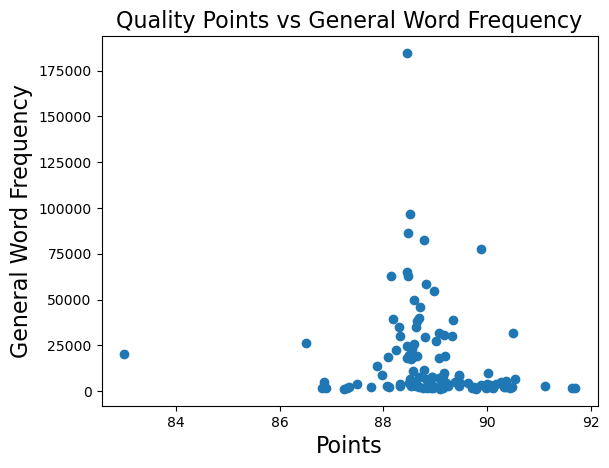

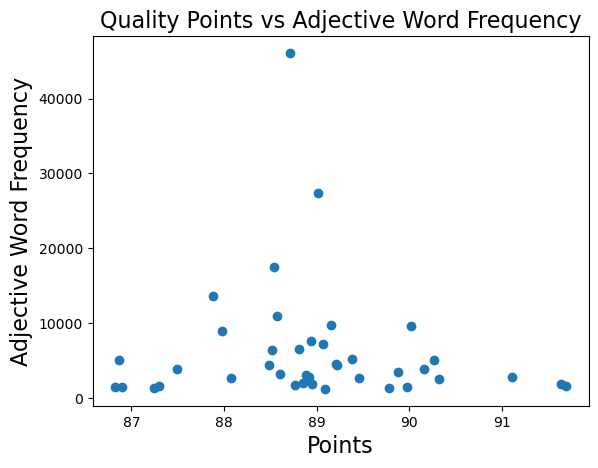

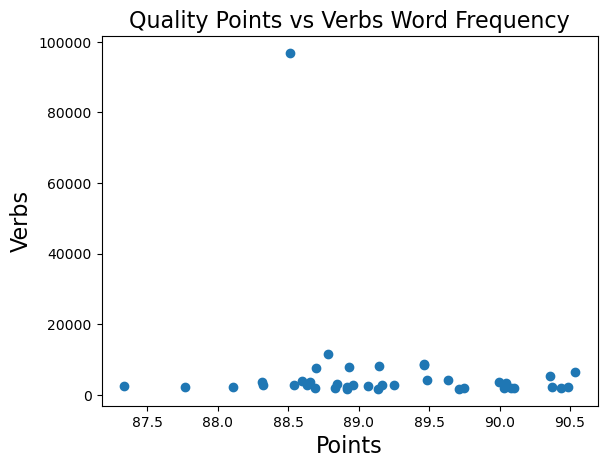

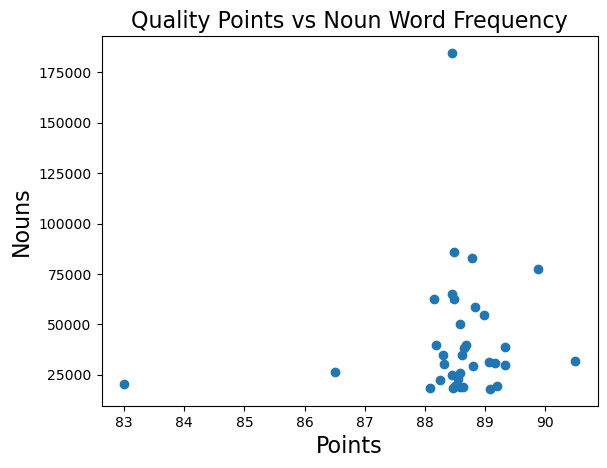

In [23]:
y_vals = [item[1] for item in general]
x_vals = [item[2] for item in general]

plt.scatter(x_vals, y_vals)
plt.xlabel('Points', fontsize=16)
plt.ylabel('General Word Frequency', fontsize=16)
plt.title("Quality Points vs General Word Frequency",fontsize = 16)
plt.show()

y_vals = [item[1] for item in adjectives]
x_vals = [item[2] for item in adjectives]

plt.scatter(x_vals, y_vals)
plt.xlabel('Points', fontsize=16)
plt.ylabel('Adjective Word Frequency', fontsize=16)
plt.title("Quality Points vs Adjective Word Frequency",fontsize = 16)
plt.show()

y_vals = [item[1] for item in verbs]
x_vals = [item[2] for item in verbs]

plt.scatter(x_vals, y_vals)
plt.xlabel('Points', fontsize=16)
plt.ylabel('Verbs', fontsize=16)
plt.title("Quality Points vs Verbs Word Frequency",fontsize = 16)
plt.show()

y_vals = [item[1] for item in nouns]
x_vals = [item[2] for item in nouns]

plt.scatter(x_vals, y_vals)
plt.xlabel('Points', fontsize=16)
plt.ylabel('Nouns', fontsize=16)
plt.title("Quality Points vs Noun Word Frequency",fontsize = 16)
plt.show()

Print the mean and standard deviation

In [24]:
nouns_df = pd.DataFrame(nouns, columns=['word', 'count','points'])
general_df = pd.DataFrame(general, columns=['word', 'count','points'])
adjective_df = pd.DataFrame(adjectives, columns=['word', 'count','points'])
verbs_df = pd.DataFrame(verbs, columns=['word', 'count','points'])


print(general_df['points'].mean())
print(general_df['points'].std())
print(adjective_df['points'].mean())
print(adjective_df['points'].std())
print(verbs_df['points'].mean())
print(verbs_df['points'].std())
print(nouns_df['points'].mean())
print(nouns_df['points'].std())

88.90944726928518
1.0705696338571744
88.96469653039807
1.1725648169214238
89.20244593241544
0.7796098727974403
88.51144964157866
1.1405908004520384


Some price values are "NaN", so lets replace them with the average price, remove duplicate wines and replace with average of each occurance, and remove any unused columns.

In [174]:
priceMean = df['price'].mean()
print(f'Average price: {priceMean}')
df['price']= df['price'].fillna(priceMean)

numDup = len(df['title']) - len(df['title'].unique())
print(f'Number of repeated entries: {numDup}')

new_df = df[['title','price', 'points']].copy()
new_df = new_df.groupby(['title']).mean()

new_df.head(10)

Average price: 35.363389129985535
Number of repeated entries: 11131


,price,points
title,,
1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),18.0,82.0
1+1=3 NV Brut Sparkling (Cava),16.0,87.0
1+1=3 NV Cygnus Brut Nature Reserva Made With Organic Grapes Sparkling (Cava),20.0,89.0
1+1=3 NV Rosé Sparkling (Cava),20.0,86.0
10 Knots 2006 Beachcomber White (Paso Robles),21.0,83.0
10 Knots 2006 Chardonnay (Santa Barbara County),21.0,85.0
10 Knots 2009 Moonraker Grenache (Paso Robles),35.0,81.0
10 Knots 2010 Viognier (Paso Robles),22.0,84.0
100 Percent Wine 2012 All Profits to Charity Red (California),18.0,89.0


Calculate a "score" (average points) for each country

In [175]:
numCountries = len(df['country'].unique())
print(f'Number of unique countries: {numCountries}')

print(df.groupby(['country'])['points'].mean().sort_values(ascending=False).head())

Number of unique countries: 44
country
England    91.581081
India      90.222222
Austria    90.101345
Germany    89.851732
Canada     89.369650
Name: points, dtype: float64


Visualize country scores

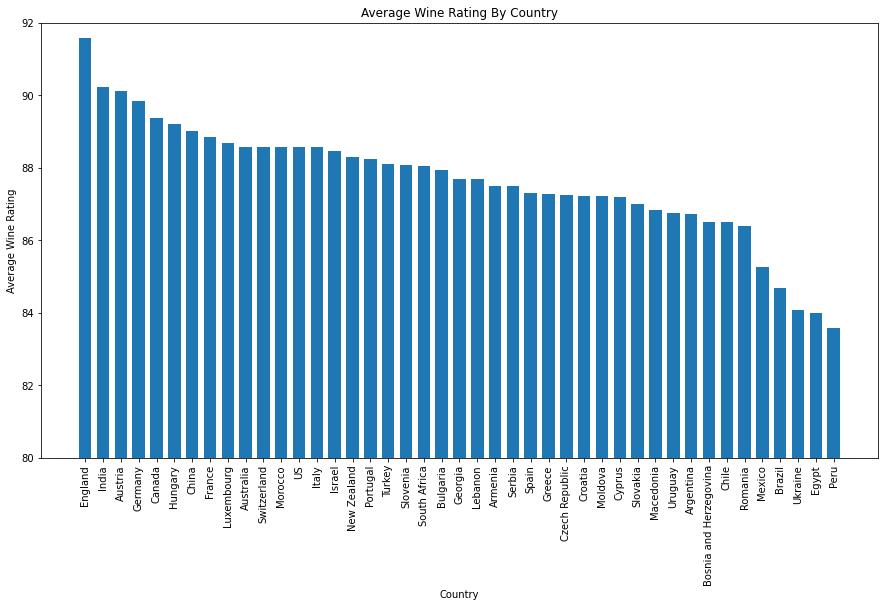

In [176]:
from matplotlib import pyplot as plt
import numpy as np

scores = df.groupby(['country'])['points'].mean().sort_values(ascending=False).tolist()
countries = df.groupby(['country'])['points'].mean().sort_values(ascending=False).index.to_list()

plt.figure(figsize=(15, 8))
plt.xlabel('Country')
plt.ylabel('Average Wine Rating')
plt.title('Average Wine Rating By Country')
plt.xticks(range(len(countries)), countries, rotation='vertical')
gr = plt.bar(countries, scores, width=0.7)
plt.ylim(80, 92)
plt.show()

Figure out which wines have the best quality-to-price ratio

In [177]:
new_df = new_df.assign(qualityToPrice=lambda x: x.points / x.price)
print(len(new_df))
#print(new_df.groupby(['title'])['qualityToPrice'].mean().sort_values(ascending=False))
new_df.describe()

118840


,price,points,qualityToPrice
count,118840.000000,118840.000000,118840.000000
mean,35.568971,88.443561,3.747793
std,40.266214,3.092570,2.176718
min,4.000000,80.000000,0.026667
25%,18.000000,86.000000,2.200000
50%,28.000000,88.000000,3.185185
75%,40.000000,91.000000,4.944444
max,3300.000000,100.000000,21.500000


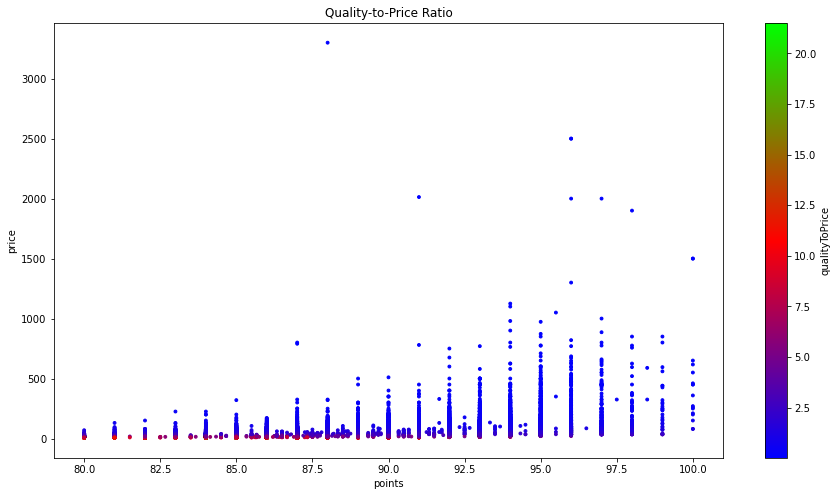

In [178]:
ax_cmap = plt.cm.get_cmap('brg')
ax = new_df.plot.scatter(x='points', y='price', c='qualityToPrice', cmap=ax_cmap, figsize=(15,8), title='Quality-to-Price Ratio', s=8, sharex=False)


Price outliers make visualising the data difficult and do not contribute to the quality-to-price ratio significantly, so let us remove them and create a new visualization.

In [179]:
len1 = len(new_df)
new_df = new_df[np.abs(new_df.price-new_df.price.mean()) <= (3*new_df.price.std())]
len2 = len(new_df)
print(f'{len1-len2} rows with outlier prices removed.')

1129 rows with outlier prices removed.


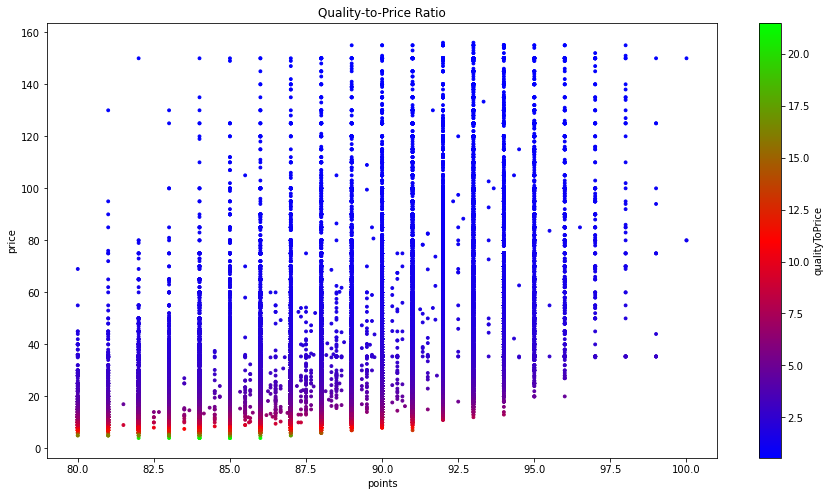

In [180]:
ax = new_df.plot.scatter(x='points', y='price', c='qualityToPrice', cmap=ax_cmap, figsize=(15,8), title='Quality-to-Price Ratio', s=8, sharex=False)


Group wines based on points and create box plots

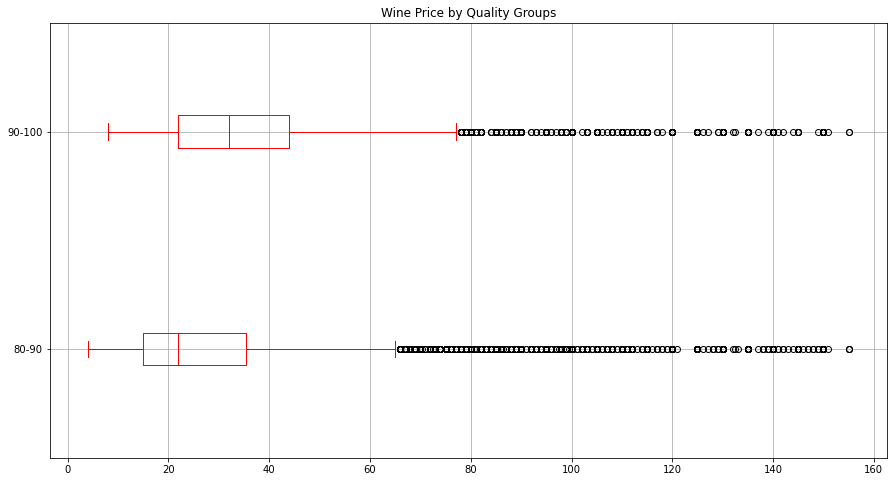

In [222]:
box = pd.DataFrame(columns=['80-90', '90-100'])
box['80-90'] = new_df[new_df.points <= 90]['price']
box['90-100'] = new_df[new_df.points >= 90]['price']

bp = box.boxplot(vert=0, figsize=(15, 8), color='red')
plt.title('Wine Price by Quality Groups')
plt.show()